# **2. Exploratory Data Analysis**

In this notebook I'll load and analyzed the dataset available for training the final model, which is located at data/Training_Essay_Data.csv (root relative).

The analyzes will include:

* Checking out the target variable balancing;

* Checking out for invalid data inputs;

* Generating a worldcloud for detecting possible valuous insights;

* Checking for possibles anomalies (language typos, for example).

## **About the Dataset**

The dataset used in this project was downloaded from Kaggle at this link: https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset

I dowloaded it and stored at data/ directory with it's the relative LICENSE file. So, that way the dataset can be easily loaded with the pandas library.

### **Variables Dictionary:**

1. **text**
    * Text generated by human or machine;

    * Unstructed data (requires preprocessing).

2. **generated**
    * Indicates if the text was generated by a machine or not;

    * Nominal data;
    
    * Possible values: 0 (not generated) or 1 (generated).

For more detail about the data, take a look at the link above.

## **Importing libraries**

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from wordcloud import WordCloud

from symspellpy import SymSpell, Verbosity
import importlib.resources

In [2]:
# setting up nltk
nltk.data.path.append('../nltk_data/')

## **Loading dataset**

In [3]:
DATASET_PATH = '../data/Training_Essay_Data.csv'
df = pd.read_csv(DATASET_PATH)

### **Splitting the data**

But before proceed, we must have some caution to avoid data leak. So I'll split the data into train and test set.

The criterias to do it will be:

* 80% of the data will be used to train the ML model;

* The division must mantain the target variable balancing.

In [4]:
df_train, df_test = train_test_split(df, random_state=42, train_size=0.8, stratify=df.generated)

# show train and test sizes
print(f'Training examples: {df_train.shape[0]}')
print(f'    Target balancing {(df_train.generated == 1).sum() / df_train.shape[0] * 100:.2f}%')

print(f'\nTesting examples: {df_test.shape[0]}')
print(f'    Target balancing {(df_test.generated == 1).sum() / df_test.shape[0] * 100:.2f}%')

Training examples: 23316
    Target balancing 39.93%

Testing examples: 5829
    Target balancing 39.92%


With this, we also answer to one of our questions: target variable balancing. 

As we can see, our dataset is **well balanced with almost 40% of the texts examples generated by AI**.

## **Visualizing dataset informations**

In [6]:
# show first dataset rows
df_train.head()

,text,generated
8311,In this essay I will talk about if the use of ...,0
26382,The importance of self-care should never be un...,1
10684,"Do you think this ""face"" was created by aliens...",0
20102,\nThe potential impact of the use of social me...,1
16282,Many people believe that self-esteem comes fro...,0


In [7]:
# show last dataset rows
df_train.tail()

,text,generated
27006,The topic of this essay is the rise of virtual...,1
6992,The author supports the idea that studying Ven...,0
22459,Broad knowledge of many academic subjects is b...,1
16609,In my opinion.\n\nI agree with Emerson to be r...,0
28995,"""Do you want to be apart of a Electoral Colleg...",0


In [8]:
# show some text example
print(df_train.iloc[10].values[0])


After contemplating which direction to take, I decided to ask two of my friends for their advice. One suggested I start my project earlier to give myself more time to work on it, while the other encouraged me to relax and enjoy my free time. While both options were insightful, I eventually chose the option that I thought would work best for me. After taking action, I realized that the decision I made was ultimately my own and not the mistake of the person who gave me the advice. I appreciated their support and thanked them both for helping me out.


In [9]:
# show dataset data informations
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23316 entries, 8311 to 28995
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       23316 non-null  object
 1   generated  23316 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 546.5+ KB


As we see above, the dataset has 23316 entries and appears to not have any null value, and also the data type looks correct.

But, for precaution, let's see it there is no empty or invalid texts or invalid numbers for the variable `generated`.

In [5]:
# check invalid strings
if (~df_train.text.str.contains('\w')).sum() > 0: # \w check for word characters
    print('Invalid values encountered!')
    display(df_train[(~df_train.text.str.contains('\w'))])
else:
    print('No invalid values encountered.')

Invalid values encountered!


,text,generated
2743,],1


In [6]:
# check invalid values for ´generated´
if (~df_train.generated.isin([0, 1])).sum() > 0:
    print('Invalid values encountered!')
    display(df_train[~df_train.generated.isin([0, 1])])
else:
    print('No invalid values encountered.')

No invalid values encountered.


The `generated` variable is ok, but `text` has one "invalid" example.

The invalid example is "]". And think on it, it doesn't bring any valuos insight to predict the target variable. And how it's just a unique example I'll just discard it.

In [7]:
# drop the invalid index 2743
df_train.drop(2743, inplace=True)

## **Building a WordCloud**

In this section I'll create a WordCloud for human and machine genrated texts. May this give us some valuable insight.

In [11]:
# separating text generated by humans and machines
human_text = df_train.text[df_train.generated == 0]
ai_text = df_train.text[df_train.generated == 1]

# join each sentence into one string
human_text_str = ' '.join(human_text.tolist())
ai_text_str = ' '.join(ai_text.tolist())

In [14]:
# tokenize texts
human_text_tokens = nltk.word_tokenize(human_text_str)
ai_text_tokens = nltk.word_tokenize(ai_text_str)

In [17]:
def remove_stopwords(text_tokens):
    '''
    Helper function to remove stopwords from the given text tokens.

    Parameters
    ---
    - text_tokens: list of text tokens to remove the stopwords.

    Returns
    ---
    - a list of tokens with stopwords removed
    '''

    clean_tokens = [word for word in text_tokens if word.lower() not in set(stopwords.words('english'))]
    return clean_tokens

def remove_irrelevant_info(text_tokens):
    '''
    Helper funtion to remove irrelevant information from the given text tokens.
    Irrelevant info can be anything that is not a letter.

    Parameters
    ---
    - text_tokens: a list of text tokens to remove the irrelevant information.

    Returns
    ---
    - a list of tokens with irrelevant informantion removed.
    '''

    clean_tokens = [word for word in text_tokens if re.match('[a-zA-Z]', word)]
    return clean_tokens

In [16]:
# clean text tokens
human_text_tokens = remove_stopwords(human_text_tokens)
human_text_tokens = remove_irrelevant_info(human_text_tokens)

ai_text_tokens = remove_stopwords(ai_text_tokens)
ai_text_tokens = remove_irrelevant_info(ai_text_tokens)

In [17]:
# create WordClouds
human_text_word_cloud = WordCloud(background_color='black',
                                  width=1600, height=800).generate(' '.join(human_text_tokens))

ai_text_word_cloud = WordCloud(background_color='black',
                               width=1600, height=800).generate(' '.join(ai_text_tokens))

### **Human Text WordCloud**

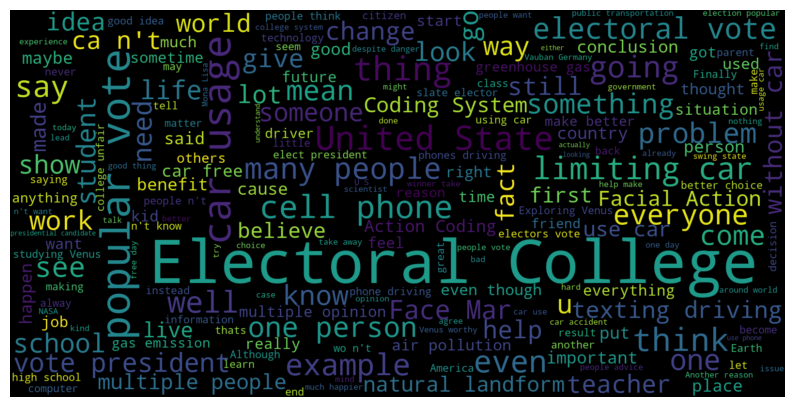

In [18]:
# plot human word cloud
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(human_text_word_cloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

### **AI Text WordCloud**

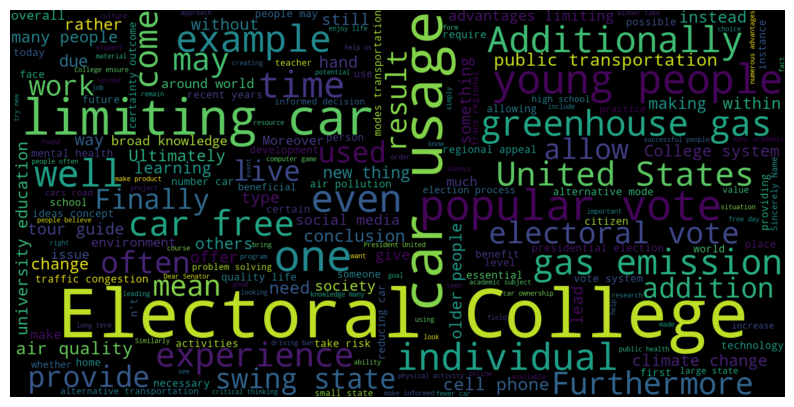

In [19]:
# plot ai word cloud
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(ai_text_word_cloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

Looking at the wordclouds above, we can just infer the context of all the texts (which seems to be very similar in both cases).
So, how I'm not interested in the specific content, I'll remove the nouns to look for some more valuable insight.

### **Removing Nouns**

In [20]:
def remove_nouns(text_tokens):
    '''
    Helper function to remove nouns from the given text tokens.

    Parameters
    ---
    - text_tokens: a list of text tokens to remove the nouns.

    Returns
    ---
    - a list of tokens with nouns removed.
    '''
    tagged = nltk.pos_tag(text_tokens)
    non_nouns_tokens = [word for (word, tag) in tagged if tag not in ['NN', 'NNS', 'NNP', 'NNPS']]

    return non_nouns_tokens

In [21]:
# clean human and ai texts
no_noun_human_text_tokens = remove_nouns(human_text_tokens)
no_noun_ai_text_tokens = remove_nouns(ai_text_tokens)

In [22]:
# create WordClouds again
no_noun_human_text_word_cloud = WordCloud(background_color='black',
                                          width=1600, height=800).generate(' '.join(no_noun_human_text_tokens))

no_noun_ai_text_word_cloud = WordCloud(background_color='black',
                                       width=1600, height=800).generate(' '.join(no_noun_ai_text_tokens))

### **No Noun Human Text WordCloud**

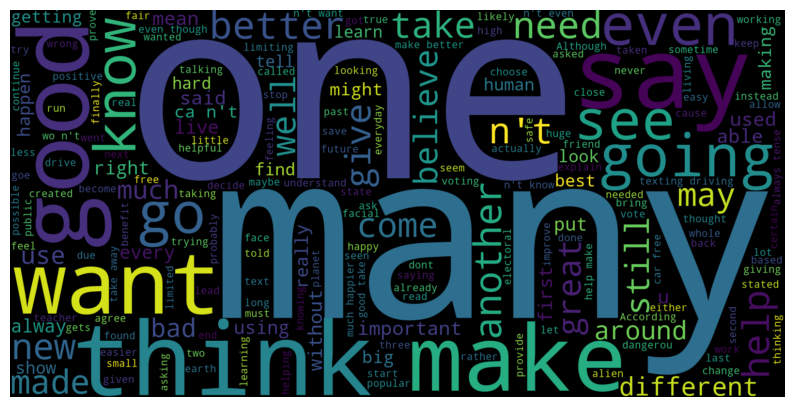

In [23]:
# plot human word cloud
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(no_noun_human_text_word_cloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

### **No Noun AI Text WordCloud**

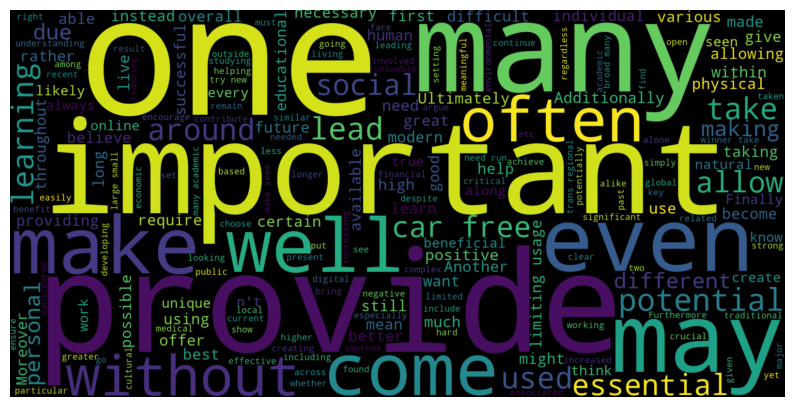

In [24]:
# plot human word cloud
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(no_noun_ai_text_word_cloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

#### **Insights**

* Even after removing the nouns, both WordClouds still look very similar.

* AI texts appear to avoid the usage of abbreviations such as 'can't', 'u' (for 'you'), and constructions like 'something'something'.

* Removing the nouns makes it possible to be less dependent on the content present in our available data to train. This means the final model may work better on other texts with completely different contexts if we ignore the nouns (this way we can focus on non-substantive linguistic elements).

To investigate the second insight, I'll count the number of abbreviations for human an AI texts, and effectuate an hypothesis test to take chance into account.

Because some english stopwords in nltk contains abbreviations (see below), I'll reprepare the data removing this abbreviations from stopwords.

In [8]:
# show nltk stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
def remove_stopwords_ignoring_abbreviations(text_tokens):
    '''
    Helper function to remove stopwords from the given text tokens, ignoring the abbreviations in the english stopwords list.

    Parameters
    ---
    - text_tokens: list of text tokens to remove the stopwords.

    Returns
    ---
    - a list of tokens with stopwords removed
    '''

    abbreviations_stopwords = [stopword for stopword in stopwords.words('english') if re.match(r'\b(\w+)\'(\w+)\b', stopword)]
    cleaned_stopwods = set(stopwords.words('english')) - set(abbreviations_stopwords)

    clean_tokens = [word for word in text_tokens if word.lower() not in cleaned_stopwods]
    
    return clean_tokens

def count_abbreviations(text_tokens):
    '''
    Helper function to count the number of abbreviations in the given text tokens.

    Parameters
    ---
    - text_tokens: a list of text tokens to count the abbreviations.

    Returns
    ---
    - the number of abbreviations.
    '''
    full_text = ' '.join(text_tokens)

    abbreviation_patterns = [
        r'\b(\w+)\'(\w+)\b',
        r'\bu\b'
    ]

    abbreviation_count = 0
    for pattern in abbreviation_patterns:
        matches = re.findall(pattern, full_text, re.IGNORECASE)
        abbreviation_count += len(matches)

    return abbreviation_count

In [18]:
# preparing text to count abbreviations

# tokenize texts
human_abbr_count_text_tokens = nltk.word_tokenize(human_text_str)
ai_abbr_count_text_tokens = nltk.word_tokenize(ai_text_str)

# remove stopwords
human_abbr_count_text_tokens = remove_stopwords_ignoring_abbreviations(human_abbr_count_text_tokens)
ai_abbr_count_text_tokens = remove_stopwords_ignoring_abbreviations(ai_abbr_count_text_tokens)

# remove irrelevant info
human_abbr_count_text_tokens = remove_irrelevant_info(human_abbr_count_text_tokens)
ai_abbr_count_text_tokens = remove_irrelevant_info(ai_abbr_count_text_tokens)

In [19]:
# count texts abbreviations
human_abbreviations_count = count_abbreviations(human_abbr_count_text_tokens)
ai_abbreviations_count = count_abbreviations(ai_abbr_count_text_tokens)

print('Human abbreviations count:', human_abbreviations_count)
print('AI abbreviations count:', ai_abbreviations_count)

Human abbreviations count: 26709
AI abbreviations count: 2024


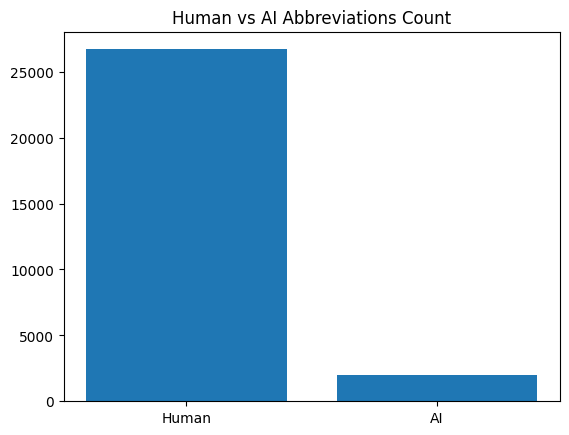

Human abbreviations count are 13.20 times higher than AI.


In [20]:
# compare results side by side
plt.bar(['Human', 'AI'], [human_abbreviations_count, ai_abbreviations_count])
plt.title('Human vs AI Abbreviations Count')
plt.show()

# show ratio difference
print(f'Human abbreviations count are {(human_abbreviations_count / ai_abbreviations_count):.2f} times higher than AI.')

As we can see above, the human abbreviations count is 13 times higher than AI typos. It can be used to help predict if the text was generated by a human or AI.

But, before going with this insight, let's do an hypothesis test to ensure the distribution observed above is not due to the case.
Consider the following:

* H0: the number of human and AI abbreviations are not significantly different.

* H1: the number of human and AI abbreviations are significantly different.

* Significance of 0.05.

* Chi-squared test.

In [21]:
# compute chi-sqaured test
chi2, p_value, dof, expected_freq = stats.chi2_contingency(observed=[
    [human_abbreviations_count, ai_abbreviations_count],
    [len(human_abbr_count_text_tokens) - human_abbreviations_count, len(ai_abbr_count_text_tokens) - ai_abbreviations_count]
])

# show result
print(f'chi-squared value: {chi2:.2f}')
print(f'p-value: {p_value:.2f}')

# interpret result
alpha = 0.05
if p_value < alpha:
    print('The difference is statistically significant.')
else:
    print('The difference is not statistically significant.')

chi-squared value: 10096.14
p-value: 0.00
The difference is statistically significant.


With the above hypothesis test we can conclude that the difference is statistically significant. So that is another point to continue with this insight.

## **Analyzing Language Typos**

Maybe a valuable insight is the number of typos made by humans and AI. So, in this section I'll count the number of typos and effectutate an hypothesis test to take chance into account.

In [28]:
def count_typos(text_tokens):
    '''
    Helper function to count the number of possible typos in the given text tokens.

    Parameters
    ---
    - text_tokens: a list of text tokens to count the typos.

    Returns
    ---
    - the number of typos.
    '''
    sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

    with importlib.resources.open_text('symspellpy', 'frequency_dictionary_en_82_765.txt') as file:
        dictionary_path = file.name
        sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

    typos_count = 0
    for word in text_tokens:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if not suggestions or suggestions[0].term != word:
            typos_count += 1

    return typos_count

In [29]:
# count the number of typos in human and AI texts
human_typos_count = count_typos(human_text_tokens)
ai_typos_count = count_typos(ai_text_tokens)

print('Human typos count:', human_typos_count)
print('AI typos count:', ai_typos_count)

Human typos count: 444913
AI typos count: 151140


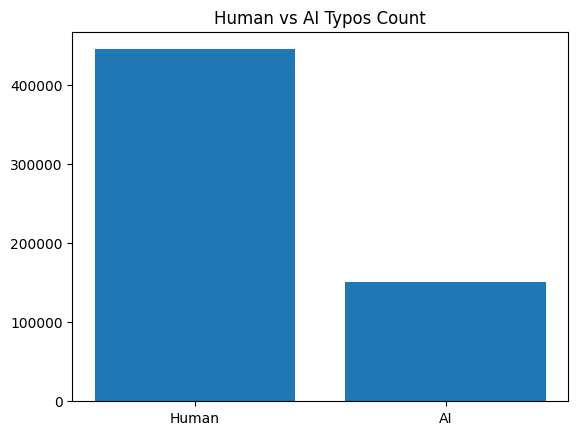

Human typos are 2.94 times higher than AI.


In [30]:
# compare results side by side
plt.bar(['Human', 'AI'], [human_typos_count, ai_typos_count])
plt.title('Human vs AI Typos Count')
plt.show()

# show ratio difference
print(f'Human typos are {(human_typos_count / ai_typos_count):.2f} times higher than AI.')

As we can see above, the human typos count is 3 times higher than AI typos. It can be used to help predict if the text was generated by a human or AI.

But, before going with this insight, let's do a hyphotesis test to ensure the distribution observed above is not due to the case.
Consider the following:

* H0: the number of human typos and AI typos are not significantly different.

* H1: the number of human typos and AI typos are significantly different.

* Significance of 0.05.

* Chi-squared test.

In [36]:
# compute chi-sqaured test
chi2, p_value, dof, expected_freq = stats.chi2_contingency(observed=[
    [human_typos_count, ai_typos_count],
    [len(human_text_tokens) - human_typos_count, len(ai_text_tokens) - ai_typos_count]
])

# show result
print(f'chi-squared value: {chi2:.2f}')
print(f'p-value: {p_value:.2f}')

# interpret result
alpha = 0.05
if p_value < alpha:
    print('The difference is statistically significant.')
else:
    print('The difference is not statistically significant.')

chi-squared value: 29499.82
p-value: 0.00
The difference is statistically significant.


With the above hypothesis test we can conclude that the difference is statistically significant. So that is another point to continue with this insight.

## **Conclusion**

The main insights we found are:

* Dataset is well balenced;

* Removing nouns make us less dependent on the dataset content;

* Text generated by AI uses less abbreviations;

* Humans make more typos than AI.